In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

In [2]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

print(f"device: {device}") if torch.cuda.is_available() else print("device: cpu")

device: cuda:1


In [5]:
# hypter parameter setting
learning_rate = 1e-1 # normally, 1e-4부터 체크하면서 올림
epochs = 30
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch SGD, 2의 배수
act = nn.Tanh()
h = 200
display_step = 5

len(train_data):  60000
len(test_data):  10000
original data shape:  torch.Size([1, 28, 28])
label:  5


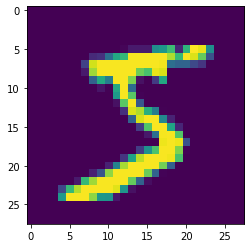

In [3]:
# load data
train_data = dataset.MNIST("./", train = True, 
                           transform = transforms.ToTensor(),
                           target_transform = None, # one-hot encoding 할지 여부
                           download = True)
test_data = dataset.MNIST("./", train = False,
                          transform = transforms.ToTensor(),
                          target_transform = None,
                          download = True)

# check the data
print('len(train_data): ', len(train_data))
print('len(test_data): ', len(test_data))

x_train, y_train = train_data[0]
print('original data shape: ', x_train.shape)
print('label: ', y_train)

plt.figure()
plt.imshow(x_train[0])
plt.show()

processed data shape: torch.Size([32, 1, 28, 28])
label: tensor([5, 5, 1, 2, 1, 3, 0, 3, 2, 4, 4, 0, 7, 3, 6, 6, 8, 3, 2, 9, 2, 9, 4, 5,
        1, 5, 4, 8, 0, 7, 4, 1])


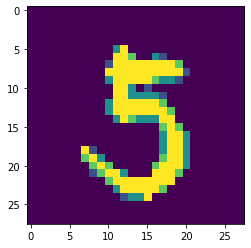

In [6]:
# Pre-process (batch, shuffle)
train_loader = torch.utils.data.DataLoader(train_data,
                                           batch_size = batch_size,
                                           shuffle = True, # 섞을지 여부
                                           num_workers = 1,
                                           drop_last = True) # 남는 거 버릴지 여부
test_loader = torch.utils.data.DataLoader(test_data,
                                          batch_size = 10000,
                                          shuffle = True,
                                          num_workers = 1,
                                          drop_last = True)

# check the data (배치 중 하나만 가져와서 확인)
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print('processed data shape:', example_data.shape)
print('label:', example_target)

plt.figure()
plt.imshow(example_data[0][0])
plt.show()

In [7]:
model = nn.Sequential(nn.Linear(np.prod(x_train.shape[1:]), 1024),
                      act,
                      nn.Linear(1024, 300),
                      act,
                      nn.Linear(300,10))

model = model.to(device)
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [8]:
loss_array = []
iteration_loss_array = []

for epoch in range(epochs):
    for iteration, [data, label] in enumerate(train_loader):
        optimizer.zero_grad()
        
        x = data.to(device)
        x = x.view(batch_size, -1)
        y = label.to(device)
        
        output = model(x)
        loss = loss_function(output, y)
        
        loss.backward()
        optimizer.step()
        
        iteration_loss_array.append(loss.cpu().detach().numpy())
        
    loss_array.append(loss.cpu().detach().numpy())
    
    if epoch % display_step == 0:
        print(f'Epoch: {epoch+1} / Loss: {loss}')

Epoch: 1 / Loss: 0.25999709963798523
Epoch: 6 / Loss: 0.21514326333999634
Epoch: 11 / Loss: 0.017176641151309013
Epoch: 16 / Loss: 0.0016373086255043745
Epoch: 21 / Loss: 0.0023478225339204073
Epoch: 26 / Loss: 0.002035269048064947


In [9]:
# test
model.eval()
correct = 0
total = 0

prediction_list = []
label_list = []

with torch.no_grad():
    for data, label in test_loader:
        x = data.to(device)
        x = x.view(-1, 784)
        y = label.to(device)
        
        prediction = model(x)
        _, prediction_index = torch.max(prediction, 1)
                
        prediction_list.append(prediction_index)
        label_list.append(y)
        
        total += y.size(0)
        correct += (prediction_index == y).sum().float()
        
print('total', total)
print('correct', correct)
print('accuracy', correct/total)

total 10000
correct tensor(9816., device='cuda:1')
accuracy tensor(0.9816, device='cuda:1')


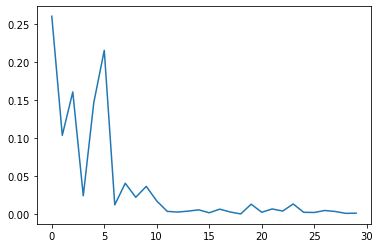

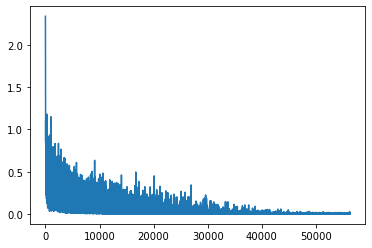

prediction : (10000,)
true label : (10000,)


array([[ 970,    0,    2,    1,    1,    1,    2,    1,    1,    1],
       [   0, 1124,    2,    2,    0,    1,    2,    1,    3,    0],
       [   4,    1, 1012,    3,    2,    0,    2,    4,    3,    1],
       [   0,    0,    2,  996,    0,    1,    0,    2,    4,    5],
       [   0,    0,    3,    1,  965,    0,    5,    1,    0,    7],
       [   2,    0,    0,    9,    1,  873,    3,    1,    1,    2],
       [   3,    2,    1,    1,    4,    3,  943,    0,    1,    0],
       [   1,    6,    6,    2,    2,    1,    0, 1002,    1,    7],
       [   2,    1,    1,    7,    3,    6,    0,    2,  950,    2],
       [   2,    2,    1,    7,    8,    3,    0,    4,    1,  981]])

In [10]:
# plot losses
plt.figure()
plt.plot(loss_array)
plt.show()
# plot iteration losses
plt.figure()
plt.plot(iteration_loss_array)
plt.show()

# confusion matrix
from sklearn.metrics import confusion_matrix
import numpy as np
    
prediction_array = np.array(prediction_list[0].cpu())
label_array = np.array(label_list[0].cpu())

print("prediction :", prediction_array.shape)
print("true label :", label_array.shape)

confusion_matrix(
    label_array,
    prediction_array) # y_pred

In [11]:
# hyper parameter setting
learning_rate = 1e-1
epochs = 100
# batch_size = 60000 # gradient descent
# batch_size = 1 # stochastic gradient descent
batch_size = 32 # mini-batch stochastic gradient descent
act = nn.Tanh()
h = 200
display_step = 10
dropout_rate = .2 # probability to be 0 

In [17]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.hidden1 = 1024
        self.hidden2 = 300
        self.final = 10
        
        self.fc1 = nn.Linear(784, self.hidden1)
        self.bn1 = nn.BatchNorm1d(self.hidden1)
        self.act1 = nn.Tanh()
        self.drop1 = nn.Dropout(dropout_rate)
        
        self.fc2 = nn.Linear(self.hidden1, self.hidden2)
        self.bn2 = nn.BatchNorm1d(self.hidden2)
        self.act2 = nn.Tanh()
        self.drop2 = nn.Dropout(dropout_rate)
        
        self.fc3 = nn.Linear(self.hidden2, self.final)
        
    def forward(self, x):
        output1 = self.fc1(x)
        bn1 = sefl.bn1(output1)
        hidden1 = self.act1(bn1)
        drop1 = self.drop1(hidden1)
        
        output2 = self.fc2(drop1)
        bn2 = self.bn2(output2)
        hidden2 = self.act2(bn2)
        drop2 = self.drop2(hidden2)
        
        logit = self.fc3(drop2)
        
        return logit
    
model = MLP().to(device)
model.train()

loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate)

In [ ]:
# hypter parameter setting
learning_rate = 1e-4
training_epochs = 100
display_step = 10
batch_size = 32
momentum = 0.9 

activation = nn.ReLU()
max_pool = nn.MaxPool2d(2,2) # kerel size, stride size, padding size 

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() # for initializing nn.Module (parent class)
        self.feature_extraction = nn.Sequential(
            # original image : 3 * 32 * 32
            nn.Conv2d(3, 10, 5) # 10 * 28 * 28
            activation,
            nn.Conv2d(10, 20, 5) # 20 * 24 * 24
            activation,
            nn.Conv2d(20, 30, 5) # 30 * 20 * 20
            activation,
            nn.Conv2d(30, 40, 5) # 40 * 16 * 16
            activation,
            max_pool             # 40 * 8 * 8
        )
        self.classifier = nn.Sequential(
            nn.Linear(40 * 8 * 8, 100),
            activation,
            nn.Linear(100, 10)
        )
    def forward(self, x):
        extracted_feature = self.feature_extraction(x) # [32, 40, 8, 8]
        flatten = extracted_feature.view(batch_size, -1) # [32, 40 * 8 * 8]
        result = self.classifier(flatten)
        return result

model = CNN().to(device)
model.train()
loss_function = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum = 0.9)